# SDM for Python Developers
##### Version 0.1.1

## Section 1. Data Settings for SDM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.geometry
import glob
import rasterio
import os
import shutil
import pyimpute
from pathlib import Path

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
# 행정구역
adm_kor = gpd.GeoDataFrame.from_file('DATA/ADM_KOR.gpkg')

# 출현지점
presence = gpd.GeoDataFrame.from_file('DATA/Zosterops_japonicus.gpkg')

# 출현지점 버퍼
bfr_dist = 100 # 100m 버퍼

In [4]:
# 임의 좌표 생성 함수
def random_points_in_gdf(gdf, size, overestimate=2):
    polygon = gdf['geometry'].unary_union # 합집합(union) 도형
    min_x, min_y, max_x, max_y = polygon.bounds # 폴리곤 영역
    ratio = polygon.area / polygon.envelope.area # 면적 비율 = 폴리곤 면적 / 경계상자 면적
    
    # 임의 좌표 생성: 포인트 개수(size) / 면적 비율(ratio) * 과대 산정(overestimate) 
    samples = np.random.uniform((min_x, min_y), (max_x, max_y), (int(size / ratio * overestimate), 2))
    multipoint = shapely.geometry.MultiPoint(samples)
    multipoint = multipoint.intersection(polygon)
    samples = np.array(multipoint)
    points = samples[np.random.choice(len(samples), size)]
    df = pd.DataFrame(points, columns=['lon', 'lat'])
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

# 비출현지점 생성 함수
def create_absence_points(presence, total_area, radius, count):
    presence_bfr = presence.to_crs(5179) # 투영좌표계
    presence_bfr['geometry'] = presence_bfr.geometry.buffer(radius)
    presence_bfr = presence_bfr.to_crs(4326) # 지리좌표계
    
    # difference = 행정구역 - 출현지점 버퍼
    res_difference = total_area.overlay(presence_bfr, how='difference')
    
    # 임의지점 생성 함수
    absence = random_points_in_gdf(res_difference, count)
    absence['CLASS'] = 0
    return absence

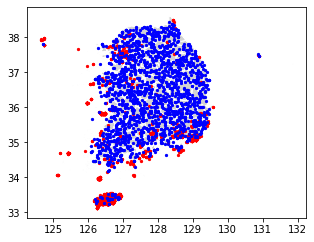

In [5]:
absence = create_absence_points(presence, adm_kor, bfr_dist, presence.shape[0]) # 비출현지점
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
adm_kor.plot(ax=ax, color='lightgray', edgecolor='white');
presence.plot(ax=ax, marker='o', color='red', markersize=5); # 출현지점
absence.plot(ax=ax, marker='o', color='blue', markersize=5); # 비출현지점

In [6]:
# 출현지점 + 비출현지점 저장
gdf = presence.append(absence, ignore_index=True)
gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf.to_file('DATA/Occurrences.gpkg', driver='GPKG', name='Occurrences')
gdf.tail()

,CLASS,lon,lat,geometry
3799,0.0,129.033003,36.215890,POINT (129.03300 36.21589)
3800,0.0,127.000081,35.000117,POINT (127.00008 35.00012)
3801,0.0,126.574643,37.004790,POINT (126.57464 37.00479)
3802,0.0,126.952337,37.337971,POINT (126.95234 37.33797)
3803,0.0,126.228204,33.308377,POINT (126.22820 33.30838)


In [7]:
# 지점 리스트
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]
print(coord_list[0:5])

[(126.282802, 33.286857), (126.521895, 33.510567), (126.530781, 33.499954), (126.490111, 33.475156), (127.079093, 37.547583)]


In [8]:
print('총 지점 개수: %s건' % '{0:,}'.format(len(coord_list)))

총 지점 개수: 3,804건


In [9]:
os.makedirs('INPUT', exist_ok = True) # 작업 디렉토리에 'INPUT(입력) 폴더 생성'
os.makedirs('OUTPUT', exist_ok = True) # 작업 디렉토리에 'OUTPUT(출력) 폴더 생성'

In [10]:
# WorldClim: Bioclimatic variables(생물기후 변수)
for f in sorted(glob.glob('DATA/BIOCLIM/bclim*.tif')): shutil.copy(f,'INPUT/')
raster_features = sorted(glob.glob('INPUT/bclim*.tif'))
print(raster_features)

['INPUT\\bclim_01.tif', 'INPUT\\bclim_02.tif', 'INPUT\\bclim_03.tif', 'INPUT\\bclim_04.tif', 'INPUT\\bclim_05.tif', 'INPUT\\bclim_06.tif', 'INPUT\\bclim_07.tif', 'INPUT\\bclim_08.tif', 'INPUT\\bclim_09.tif', 'INPUT\\bclim_10.tif', 'INPUT\\bclim_11.tif', 'INPUT\\bclim_12.tif', 'INPUT\\bclim_13.tif', 'INPUT\\bclim_14.tif', 'INPUT\\bclim_15.tif', 'INPUT\\bclim_16.tif', 'INPUT\\bclim_17.tif', 'INPUT\\bclim_18.tif', 'INPUT\\bclim_19.tif']


In [11]:
print('생물기후 변수: %s건' % len(raster_features))

생물기후 변수: 19건


In [12]:
# 포인트 샘플링
for f in raster_features:
    src = rasterio.open(f)
    gdf[Path(f).stem] = [x for x in src.sample(coord_list)]
    gdf[Path(f).stem] = gdf[Path(f).stem].astype('float64')
train_vec = gdf[gdf.columns.difference(['lon', 'lat', 'geometry'])] # 컬럼 제외
train_vec.head()

,CLASS,bclim_01,bclim_02,bclim_03,bclim_04,bclim_05,bclim_06,bclim_07,bclim_08,bclim_09,bclim_10,bclim_11,bclim_12,bclim_13,bclim_14,bclim_15,bclim_16,bclim_17,bclim_18,bclim_19
0,1.0,15.108334,6.750000,24.816177,752.262756,28.900000,1.7,27.199999,23.950001,8.200000,24.516666,5.983333,1758.0,282.0,51.0,55.859783,783.0,193.0,692.0,195.0
1,1.0,15.616667,6.783334,24.756693,764.749939,29.700001,2.3,27.400002,24.716667,8.500000,25.183334,6.350000,1728.0,275.0,51.0,55.244469,774.0,195.0,699.0,198.0
2,1.0,15.229167,6.825000,24.818182,764.444092,29.299999,1.8,27.500000,24.299999,8.116667,24.766666,5.933333,1779.0,288.0,52.0,56.042423,804.0,200.0,727.0,202.0
3,1.0,15.045834,6.791667,24.696972,764.476807,29.100000,1.6,27.500000,24.116667,7.916667,24.583332,5.750000,1788.0,292.0,52.0,56.432671,811.0,200.0,731.0,203.0
4,1.0,12.008333,8.966667,24.907408,1012.860107,29.000000,-7.0,36.000000,23.566666,-0.950000,23.950001,-0.950000,1322.0,333.0,21.0,96.840347,795.0,71.0,779.0,71.0


In [13]:
# 생물기후 변수 이름
columns = list(train_vec.columns[1:20])
print(columns)

['bclim_01', 'bclim_02', 'bclim_03', 'bclim_04', 'bclim_05', 'bclim_06', 'bclim_07', 'bclim_08', 'bclim_09', 'bclim_10', 'bclim_11', 'bclim_12', 'bclim_13', 'bclim_14', 'bclim_15', 'bclim_16', 'bclim_17', 'bclim_18', 'bclim_19']


In [14]:
# 포인트 샘플링 시 NODATA 오류 탐색: 생물기후 변수가 같은 값
nodata_df = train_vec[train_vec[columns].nunique(axis=1) == 1]
nodata_df.head()

,CLASS,bclim_01,bclim_02,bclim_03,bclim_04,bclim_05,bclim_06,bclim_07,bclim_08,bclim_09,bclim_10,bclim_11,bclim_12,bclim_13,bclim_14,bclim_15,bclim_16,bclim_17,bclim_18,bclim_19
22,1.0,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
34,1.0,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
35,1.0,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
37,1.0,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
39,1.0,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38


In [15]:
# 학습 데이터 저장
train_vec.drop(nodata_df.index).to_csv('INPUT/TRAIN_VEC.csv',index=False)
train_vec = pd.read_csv("INPUT/TRAIN_VEC.csv")
train_vec.head()

,CLASS,bclim_01,bclim_02,bclim_03,bclim_04,bclim_05,bclim_06,bclim_07,bclim_08,bclim_09,bclim_10,bclim_11,bclim_12,bclim_13,bclim_14,bclim_15,bclim_16,bclim_17,bclim_18,bclim_19
0,1.0,15.108334,6.750000,24.816177,752.262756,28.900000,1.7,27.199999,23.950001,8.200000,24.516666,5.983333,1758.0,282.0,51.0,55.859783,783.0,193.0,692.0,195.0
1,1.0,15.616667,6.783334,24.756693,764.749939,29.700001,2.3,27.400002,24.716667,8.500000,25.183334,6.350000,1728.0,275.0,51.0,55.244469,774.0,195.0,699.0,198.0
2,1.0,15.229167,6.825000,24.818182,764.444092,29.299999,1.8,27.500000,24.299999,8.116667,24.766666,5.933333,1779.0,288.0,52.0,56.042423,804.0,200.0,727.0,202.0
3,1.0,15.045834,6.791667,24.696972,764.476807,29.100000,1.6,27.500000,24.116667,7.916667,24.583332,5.750000,1788.0,292.0,52.0,56.432671,811.0,200.0,731.0,203.0
4,1.0,12.008333,8.966667,24.907408,1012.860107,29.000000,-7.0,36.000000,23.566666,-0.950000,23.950001,-0.950000,1322.0,333.0,21.0,96.840347,795.0,71.0,779.0,71.0


## Section 2. Species Suitability Mapping

In [16]:
# 학습데이터(training data): 설명변수(explanatory variables)와 반응변수(response variables)로 구성
train_xs, train_y = train_vec.iloc[:,1:20].values, train_vec.iloc[:,0].values
# 목표데이터(target data): 래스터 데이터셋으로 표현되는 설명변수(explanatory variables)만으로 구성
target_xs, raster_info = pyimpute.load_targets(raster_features)
# 학습데이터 shape 확인
train_xs.shape, train_y.shape

((3582, 19), (3582,))

In [17]:
# ML 분류기
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트
from sklearn.ensemble import ExtraTreesClassifier # 엑스트라트리
from sklearn.ensemble import AdaBoostClassifier # 아다부스트
from sklearn.ensemble import BaggingClassifier # 배깅
from sklearn.ensemble import GradientBoostingClassifier # 그레디언트부스팅
from xgboost import XGBClassifier # 엑스지부스트
from lightgbm import LGBMClassifier # 라이트그레디언트부스팅
from sklearn.linear_model import LogisticRegression # 로지스틱회귀
from sklearn import model_selection # 모델 선택
from sklearn import metrics # 평가지표

In [18]:
# ML 분류기 딕셔너리: 이름, (모델)
CLASS_MAP = {
    'RF': (RandomForestClassifier()), # 랜덤포레스트
    'ET': (ExtraTreesClassifier()), # 엑스트라트리
    'ADA' : (AdaBoostClassifier()), # 아다부스트
    'BAG' : (BaggingClassifier()), # 배깅
    'GRA' : (GradientBoostingClassifier()), # 그레디언트부스팅
    'XGB': (XGBClassifier()), # 엑스지부스트
    'LGBM': (LGBMClassifier()), # 라이트그레디언트부스팅
    'Maxent':(LogisticRegression()), # 로지스틱회귀(맥센트)
    }

In [19]:
# ROC 곡선 플롯
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [20]:
# 분류기 평가 함수 (pyimpute 함수 수정)
def evaluate_clf(
    clf, X, y, name, k=None, test_size=0.2, scoring="f1_weighted", feature_names=None
):
    X_train, X_test, y_train, y_true = model_selection.train_test_split(
        X, y,
        test_size=test_size, # 시험데이터 비율
        shuffle=True, # 분할 전 데이터 섞기
        stratify=y # y의 출현/비출현 비율 유지
    )

    if k: # 교차검증
        kf = model_selection.KFold(n_splits=k) # k-fold
        scores = model_selection.cross_val_score(clf, X_train, y_train, cv=kf, scoring=scoring)
        print(name + " %d-fold Cross Validation Accuracy(교차검증 정확도): %0.2f (+/- %0.2f)"
              % (k, scores.mean() * 100, scores.std() * 200))
        print()
    
    clf.fit(X_train, y_train) # 분류기 훈련
    y_pred = clf.predict(X_test) # 분류기 예측
    
    # 분류기 평가 지표
    print("Accuracy Score(정확도 점수): %.2f" % metrics.accuracy_score(y_true, y_pred))
    print()

    print("Classification report(분류 보고서)")
    print(metrics.classification_report(y_true, y_pred))
    print()

    print("Confussion matrix(혼동행렬)")
    print(metrics.confusion_matrix(y_true, y_pred))
    print()
    
    print('AUC(ROC 곡선 아래 면적): %.2f'% metrics.roc_auc_score(y_true, y_pred))
    print()
       
    # ROC 곡선
    probs = clf.predict_proba(X_test) 
    prob = probs[:, 1]  
    fper, tper, thresholds = metrics.roc_curve(y_true, prob)
    plot_roc_curve(fper, tper)

    if hasattr(clf, "feature_importances_"):
        print("Feature importances(특성 중요도)")
        for f, imp in zip(feature_names, clf.feature_importances_):
            print("%20s: %s" % (f, round(imp * 100, 1)))
        print()

RF 5-fold Cross Validation Accuracy(교차검증 정확도): 94.06 (+/- 1.15)

Accuracy Score(정확도 점수): 0.94

Classification report(분류 보고서)
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       377
         1.0       0.94      0.93      0.93       340

    accuracy                           0.94       717
   macro avg       0.94      0.94      0.94       717
weighted avg       0.94      0.94      0.94       717


Confussion matrix(혼동행렬)
[[355  22]
 [ 23 317]]

AUC(ROC 곡선 아래 면적): 0.94



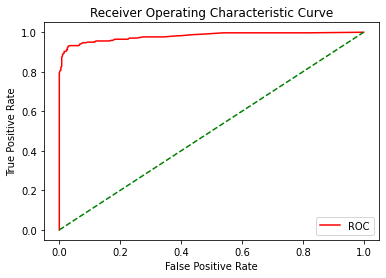

Feature importances(특성 중요도)
            bclim_01: 3.6
            bclim_02: 17.3
            bclim_03: 15.3
            bclim_04: 6.9
            bclim_05: 1.4
            bclim_06: 8.3
            bclim_07: 10.1
            bclim_08: 2.1
            bclim_09: 4.5
            bclim_10: 1.9
            bclim_11: 6.7
            bclim_12: 4.5
            bclim_13: 2.0
            bclim_14: 1.7
            bclim_15: 3.2
            bclim_16: 3.0
            bclim_17: 2.2
            bclim_18: 2.5
            bclim_19: 2.6

ET 5-fold Cross Validation Accuracy(교차검증 정확도): 93.40 (+/- 2.18)

Accuracy Score(정확도 점수): 0.95

Classification report(분류 보고서)
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       377
         1.0       0.96      0.93      0.94       340

    accuracy                           0.95       717
   macro avg       0.95      0.95      0.95       717
weighted avg       0.95      0.95      0.95       717


Confussion matrix(혼동행

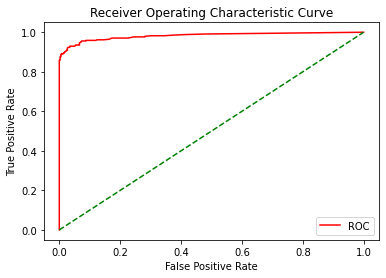

Feature importances(특성 중요도)
            bclim_01: 4.4
            bclim_02: 12.3
            bclim_03: 10.7
            bclim_04: 7.1
            bclim_05: 2.1
            bclim_06: 6.7
            bclim_07: 10.3
            bclim_08: 2.5
            bclim_09: 6.8
            bclim_10: 2.7
            bclim_11: 5.0
            bclim_12: 3.9
            bclim_13: 2.5
            bclim_14: 4.3
            bclim_15: 3.8
            bclim_16: 2.9
            bclim_17: 5.0
            bclim_18: 2.9
            bclim_19: 4.1

ADA 5-fold Cross Validation Accuracy(교차검증 정확도): 90.01 (+/- 3.24)

Accuracy Score(정확도 점수): 0.87

Classification report(분류 보고서)
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88       377
         1.0       0.86      0.87      0.87       340

    accuracy                           0.87       717
   macro avg       0.87      0.87      0.87       717
weighted avg       0.87      0.87      0.87       717


Confussion matrix(혼동

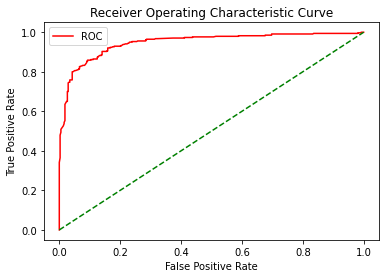

Feature importances(특성 중요도)
            bclim_01: 6.0
            bclim_02: 22.0
            bclim_03: 12.0
            bclim_04: 2.0
            bclim_05: 4.0
            bclim_06: 2.0
            bclim_07: 6.0
            bclim_08: 4.0
            bclim_09: 2.0
            bclim_10: 4.0
            bclim_11: 0.0
            bclim_12: 2.0
            bclim_13: 6.0
            bclim_14: 4.0
            bclim_15: 2.0
            bclim_16: 8.0
            bclim_17: 8.0
            bclim_18: 4.0
            bclim_19: 2.0

BAG 5-fold Cross Validation Accuracy(교차검증 정확도): 93.57 (+/- 0.98)

Accuracy Score(정확도 점수): 0.91

Classification report(분류 보고서)
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       377
         1.0       0.94      0.87      0.90       340

    accuracy                           0.91       717
   macro avg       0.92      0.91      0.91       717
weighted avg       0.91      0.91      0.91       717


Confussion matrix(혼동행

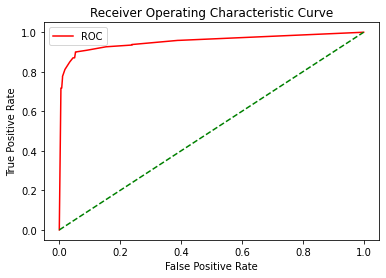

GRA 5-fold Cross Validation Accuracy(교차검증 정확도): 91.93 (+/- 0.67)

Accuracy Score(정확도 점수): 0.91

Classification report(분류 보고서)
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       377
         1.0       0.92      0.90      0.91       340

    accuracy                           0.91       717
   macro avg       0.91      0.91      0.91       717
weighted avg       0.91      0.91      0.91       717


Confussion matrix(혼동행렬)
[[349  28]
 [ 34 306]]

AUC(ROC 곡선 아래 면적): 0.91



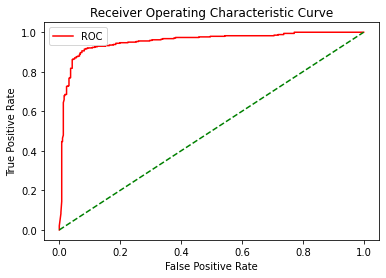

Feature importances(특성 중요도)
            bclim_01: 4.1
            bclim_02: 65.0
            bclim_03: 12.8
            bclim_04: 1.5
            bclim_05: 0.6
            bclim_06: 0.6
            bclim_07: 1.4
            bclim_08: 0.5
            bclim_09: 2.3
            bclim_10: 0.9
            bclim_11: 0.6
            bclim_12: 2.5
            bclim_13: 0.8
            bclim_14: 0.8
            bclim_15: 1.0
            bclim_16: 1.7
            bclim_17: 1.0
            bclim_18: 1.3
            bclim_19: 0.5

XGB 5-fold Cross Validation Accuracy(교차검증 정확도): 93.19 (+/- 0.96)

Accuracy Score(정확도 점수): 0.95

Classification report(분류 보고서)
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       377
         1.0       0.97      0.91      0.94       340

    accuracy                           0.95       717
   macro avg       0.95      0.94      0.95       717
weighted avg       0.95      0.95      0.95       717


Confussion matrix(혼동행

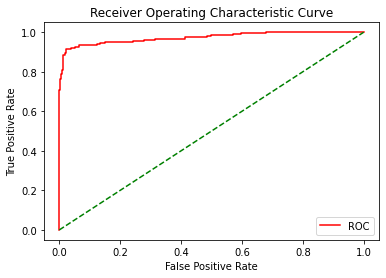

Feature importances(특성 중요도)
            bclim_01: 5.5
            bclim_02: 44.6
            bclim_03: 5.3
            bclim_04: 3.0
            bclim_05: 3.4
            bclim_06: 2.0
            bclim_07: 2.7
            bclim_08: 2.8
            bclim_09: 3.1
            bclim_10: 2.5
            bclim_11: 2.1
            bclim_12: 3.1
            bclim_13: 2.0
            bclim_14: 4.1
            bclim_15: 2.5
            bclim_16: 2.8
            bclim_17: 4.0
            bclim_18: 2.9
            bclim_19: 1.7

LGBM 5-fold Cross Validation Accuracy(교차검증 정확도): 93.51 (+/- 1.45)

Accuracy Score(정확도 점수): 0.94

Classification report(분류 보고서)
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       377
         1.0       0.93      0.94      0.94       340

    accuracy                           0.94       717
   macro avg       0.94      0.94      0.94       717
weighted avg       0.94      0.94      0.94       717


Confussion matrix(혼동행

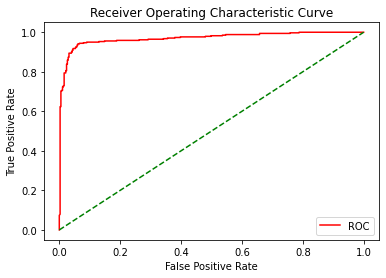

Feature importances(특성 중요도)
            bclim_01: 18000
            bclim_02: 24900
            bclim_03: 25800
            bclim_04: 20300
            bclim_05: 11700
            bclim_06: 7900
            bclim_07: 15100
            bclim_08: 22900
            bclim_09: 17600
            bclim_10: 13200
            bclim_11: 5400
            bclim_12: 20200
            bclim_13: 16600
            bclim_14: 9400
            bclim_15: 21300
            bclim_16: 15000
            bclim_17: 13700
            bclim_18: 17700
            bclim_19: 3300

Maxent 5-fold Cross Validation Accuracy(교차검증 정확도): 88.24 (+/- 1.18)

Accuracy Score(정확도 점수): 0.87

Classification report(분류 보고서)
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       377
         1.0       0.90      0.82      0.86       340

    accuracy                           0.87       717
   macro avg       0.88      0.87      0.87       717
weighted avg       0.88      0.87      0.8

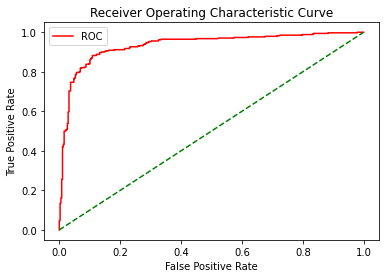

In [21]:
# 공간 예측
for name, model in CLASS_MAP.items():
    evaluate_clf(model, train_xs, train_y, name, k=5, test_size=0.2, scoring="f1_weighted", feature_names=columns)
    try:
        os.mkdir('OUTPUT/' + name + '-IMAGES')        
    except:
        pass    
    pyimpute.impute(target_xs, model, raster_info, outdir='OUTPUT/' + name + '-IMAGES', class_prob=True, certainty=True)

In [22]:
distr_rf = rasterio.open("OUTPUT/RF-IMAGES/probability_1.0.tif").read(1) # 랜덤포레스트
distr_et = rasterio.open("OUTPUT/ET-IMAGES/probability_1.0.tif").read(1) # 엑스트라트리
distr_ada =  rasterio.open("OUTPUT/ADA-IMAGES/probability_1.0.tif").read(1) # 아다부스트
distr_bag =  rasterio.open("OUTPUT/BAG-IMAGES/probability_1.0.tif").read(1) # 배깅
distr_gra =  rasterio.open("OUTPUT/GRA-IMAGES/probability_1.0.tif").read(1) # 그레디언트부스팅
distr_xgb =  rasterio.open("OUTPUT/XGB-IMAGES/probability_1.0.tif").read(1) # 엑스지부스트
distr_lgbm =  rasterio.open("OUTPUT/LGBM-IMAGES/probability_1.0.tif").read(1) # 라이트그레디언트부스팅
distr_max =  rasterio.open("OUTPUT/Maxent-IMAGES/probability_1.0.tif").read(1) # 맥센트

distr_averaged = (distr_bag + distr_xgb + distr_lgbm) / 3

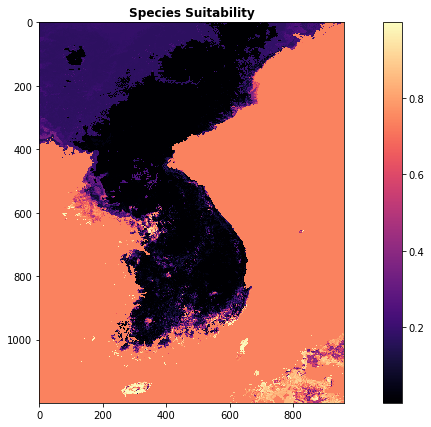

In [23]:
# 종 적합성 지도의 평균값 가시화
def plotit(x, title, cmap="Blues"):
    plt.figure(figsize = (14,7))
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')
plotit(distr_averaged, "Species Suitability", cmap="magma")

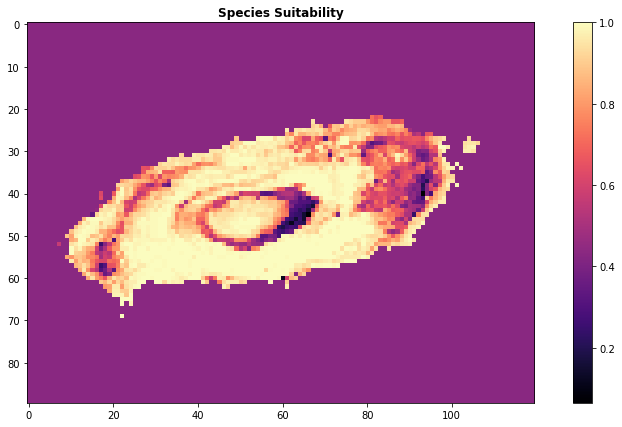

In [24]:
# 종 적합성 지도의 평균값 가시화 (확대)
plotit(distr_rf[1110:1200, 250:370], "Species Suitability", cmap="magma")